<a href="https://colab.research.google.com/github/dangtbthi/variational-autoencoder-mnist/blob/main/vae_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm

%pip install torchinfo -q
from torchinfo import summary

# Dataset

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# VAE Model

Given a large dataset of identically distributed independent samples of a random variable $\mathbf{x}$. We assume that our data has an underlying latent distribution, which means the process of generating the data is dependent on a latent variable $\mathbf{z}$ that comes from a simple prior distribution.Standard Gaussian distribution is a common choice for the prior:

$$
\mathbf{z} \sim \mathcal{N}(0, I)\\
\mathbf{x}|\mathbf{z} \sim \mathcal{N}(μ_θ(\mathbf{z}),𝚺_θ(\mathbf{z}))
$$
where $μ_θ$ and $𝚺_θ$ are neural networks parameterized by $θ$.

Our goal is to generate new samples from $\mathbf{x}$, including sample $\mathbf{z}$ and feed $\mathbf{z}$ through the two neural networks, then sample $\mathbf{x}$ from $p(\mathbf{x}|\mathbf{z};θ)$.\
We train out model via maximum likelihood estimation (MLE):
$$
\hat{\theta}_{\mathrm{MLE}} = \arg\max_\theta \, \log p(\mathbf{x};θ) = \arg\max_\theta \, \log \prod_x p(x;θ)= \sum_x \log p(x;θ)
$$
where
$$
\log p(\mathbf{x};θ) = \log \prod_x p(x;θ) = \sum_x \log p(x;θ) = \sum_x \log \sum_z p(\mathbf{x},\mathbf{z};θ)
$$
The problems arise when $p(\mathbf{x},\mathbf{z};θ)$ is intractable. Thus, we compute the marginal likelihood $ p(\mathbf{x};θ)$ via importance sampling and variational inference.

**Importance Sampling**

$$
p_\theta(\mathbf{x}) = \sum_{\mathbf{z}} p_\theta(\mathbf{x}, \mathbf{z}) = \sum_{\mathbf{z}} \frac{q(\mathbf{z})}{q(\mathbf{z})} p_\theta(\mathbf{x}, \mathbf{z}) = \mathbb{E}_{\mathbf{z} \sim q(\mathbf{z})} \left[ \frac{p_\theta(\mathbf{x}, \mathbf{z})}{q(\mathbf{z})} \right]
$$
where $q(\mathbf{z})$ is the proposal distribution.\
Therefore:
$$
\log p_\theta(\mathbf{x}) = \log \sum_{\mathbf{z}} \frac{q(\mathbf{z})}{q(\mathbf{z})} p_\theta(\mathbf{x}, \mathbf{z}) = \log \mathbb{E}_{\mathbf{z} \sim q(\mathbf{z})} \left[ \frac{p_\theta(\mathbf{x}, \mathbf{z})}{q(\mathbf{z})} \right]
$$



**Variational Inference**

$\log()$ is a concave function. Use Jensen inequality:
$$
\log p_\theta(\mathbf{x})
= \log \mathbb{E}_{\mathbf{z} \sim q(\mathbf{z})} \left[ \frac{p_\theta(\mathbf{x}, \mathbf{z})}{q(\mathbf{z})} \right]
\ge \mathbb{E}_{\mathbf{z} \sim q(\mathbf{z})} \left[ \log \frac{p_\theta(\mathbf{x}, \mathbf{z})}{q(\mathbf{z})} \right]
$$
This is called Evidence Lower Bound (**ELBO**).\
The equality holds iff $q(\mathbf{z}) = p(\mathbf{z}|\mathbf{x})$. This can be proved via Kullback-Leibler Divergence:
$$
D_{\mathrm{KL}}(q(\mathbf{z}) \| p(\mathbf{z} \mid \mathbf{x}))
= \sum_{\mathbf{z}} q(\mathbf{z}) \log \frac{q(\mathbf{z})}{p(\mathbf{z} \mid \mathbf{x})}
= \mathbb{E}_{\mathbf{z} \sim q(\mathbf{z})} \left[ \log \frac{q(\mathbf{z})}{p(\mathbf{z} \mid \mathbf{x})} \right] \ge 0
$$
The equality holds iff $q(\mathbf{z}) = p(\mathbf{z}|\mathbf{x})$ because then $D_{\mathrm{KL}}(q(\mathbf{z}) \| p(\mathbf{z} \mid \mathbf{x}))
= 0$.

In general,
\begin{align}
D_{\text{KL}}(q(\mathbf{z}) \| p(\mathbf{z} \mid \mathbf{x})) &= \sum_{\mathbf{z}} q(\mathbf{z}) \log \frac{q(\mathbf{z})}{p_θ(\mathbf{z} \mid \mathbf{x})} \ge 0 \\
&= \sum_{\mathbf{z}} q(\mathbf{z}) \log \frac{q(\mathbf{z})}{p_\theta(\mathbf{x},\mathbf{z}) / p_\theta(\mathbf{x})} \\
&= \sum_{\mathbf{z}} q(\mathbf{z}) \log \frac{q(\mathbf{z}) p_\theta(\mathbf{x})}{p_\theta(\mathbf{x},\mathbf{z})} \\
&= \sum_{\mathbf{z}} q(\mathbf{z}) \log \frac{q(\mathbf{z})}{p_\theta(\mathbf{x},\mathbf{z})} + \log p_\theta(\mathbf{x}) \\
\Rightarrow \log p_\theta(\mathbf{x}) &= \sum_{\mathbf{z}} q(\mathbf{z}) \log \frac{p_\theta(\mathbf{x},\mathbf{z})}{q(\mathbf{z})} + D_{\text{KL}}(q(\mathbf{z}) \| p(\mathbf{z} \mid \mathbf{x})) \\
&= \text{ELBO} + D_{\text{KL}}(q(\mathbf{z}) \| p(\mathbf{z} \mid \mathbf{x}))
\end{align}


Another problem we have to face is that the posterior $p(\mathbf{z}|\mathbf{x})$ is likely intractable. The proposed solution is to approximate this distribution via the encoder network with a tractable probability distribution $q$ with parameters $ϕ$ (variational parameters).

Here comes the idea of variational inference: Pick $ϕ$ so that $q(\mathbf{z};ϕ)$ is as close as possible to the true posterior $p(\mathbf{z}|\mathbf{x};θ)$, which is the core idea of the encoder.

Another interpretation of $\log p_\theta(\mathbf{x})$:
$$
\log p_\theta(x) = \sum_z q(z) \log \frac{p_\theta(x,z)}{q(z)} + D_{\rm KL}\big(q(z)\|p_\theta(z|x)\big) \\
= \sum_z q(z) \log p_\theta(x|z) + \sum_z q(z) \log \frac{p(z)}{q(z)} + D_{\rm KL}\big(q(z)\|p_\theta(z|x)\big) \\
= \mathbb{E}_{z \sim q(z|x)}[\log p_\theta(x|z)] - D_{\rm KL}(q(z|x)\|p(z)) + D_{\rm KL}(q(z|x)\|p_\theta(z|x))\\
≤ \mathbb{E}_{z \sim q(z|x)}[\log p_\theta(x|z)] - D_{\rm KL}(q(z|x)\|p(z))
$$
where:


*   $\mathbb{E}_{z \sim q(z|x)}[\log p_\theta(x|z)]$ is the reconstruction term. $q_ϕ(\mathbf{z}|\mathbf{x})$ is the ecoder, $p_θ(\mathbf{x}|\mathbf{z})$ is the decoder. This term, therefore, measures how well the decoder can reconstruct $x$ from a latent representation $z$ that was encoded by the encoder. Maximizing this term is equivalent to minimizing a "reconstruction loss," such as Mean Squared Error (MSE) for image data or Binary Cross-Entropy for binary data.
*   KL-Divergence forces the distributions $q_ϕ(\mathbf{z}|\mathbf{x})$ stays close to the prior distribution $p(\mathbf{z})$, which is chosen to be standard Gaussian in this project.

**Reparameterization Trick**

A technical challenge arises: how do we backpropagate gradients through the random sampling step $z$? This step is stochastic and non-differentiable.

One solution is instead of sampling $z$ from:
$$
z \sim \mathcal{N}(μ,σ^2)
$$
We have:
$$
z = μ + σϵ
$$
where $ϵ$ is a noise variable distributed from $\mathcal{N}(0;I)$

To summarize, here is the workflow of VAE model:


1.   Input Image: The model starts with an input data point, such as an image.
2.   Encoder: The input image $x$ is passed through the encoder network. The encoder outputs the parameters of a probability distribution—typically the mean (μ) and standard deviation σ that define a Gaussian distribution in the latent space.
3.   Reparameterization & Sampling: A latent vector z is sampled from the distribution defined by μ and σ using the reparameterization trick.
4.   Decoder: The sampled latent vector z is then fed into the decoder network.
5.   Output Image: The decoder reconstructs the data from the latent vector z, producing an output image x' that should resemble the original input image.


The training process of a VAE is a balance between these two objectives: maximizing the reconstruction term and minimizing the KL Divergence.


In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        # encoder
        self.img2hid = nn.Linear(input_dim, hidden_dim)
        self.hid2mu = nn.Linear(hidden_dim, latent_dim)
        self.hid2sigma = nn.Linear(hidden_dim, latent_dim)

        # decoder
        self.latent2hid = nn.Linear(latent_dim, hidden_dim)
        self.hid2img = nn.Linear(hidden_dim, input_dim)

        self.relu = nn.ReLU()


    def encoder(self, x):
        ''' q_phi(z|x) '''
        h = self.relu(self.img2hid(x))
        mu, sigma = self.hid2mu(h), self.hid2sigma(h)
        return mu, sigma


    def decoder(self, z):
        ''' p_theta(x|z) '''
        h = self.relu(self.latent2hid(z))
        x = self.hid2img(h)
        return torch.sigmoid(x) # ensure the output be between 0 and 1

    def forward(self, x):
        # Explicitly flatten the input before passing to encoder
        x = x.view(x.size(0), -1)
        mu, sigma = self.encoder(x)
        z_reparameterized = mu + sigma * torch.randn_like(sigma) # cùng shape với sigma
        x_recon = self.decoder(z_reparameterized)
        return x_recon, mu, sigma

    def loss_fn(self,x):
        x_recon, mu, sigma = self(x)
        # Flatten the original input for loss calculation
        x = x.view(-1, self.input_dim)
        reconstruction_loss = nn.BCELoss(reduction='sum')(x_recon, x)
        kl_divergence = -0.5 * torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
        return reconstruction_loss + kl_divergence

    @torch.no_grad()
    def sample(self, num_samples, device):
        z = torch.randn(num_samples, self.latent_dim).to(device)
        samples = self.decoder(z)
        return samples

# Train model

In [ ]:
def train(model, train_dataloader, optimizer, device):
    model.to(device)
    model.train()

    for i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        # Scale input image to be between 0 and 1 for BCELoss
        X = (X + 1) / 2.0
        optimizer.zero_grad()
        pred = model(X)
        loss = model.loss_fn(X)
        loss.backward()
        optimizer.step()

In [ ]:
batch_size = 128
input_dim = 28*28
hidden_dim = 500
latent_dim = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

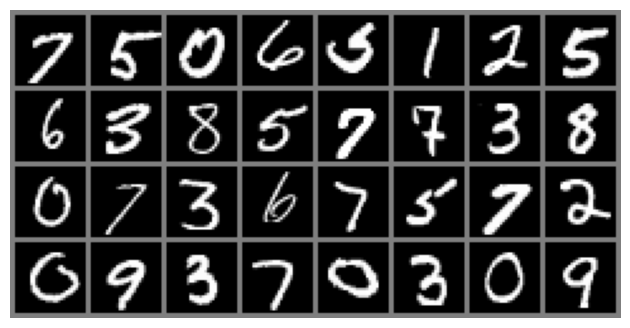

tensor([7, 5, 0, 6, 5, 1, 2, 5, 6, 3, 8, 5, 7, 7, 3, 8, 0, 7, 3, 6, 7, 5, 7, 2,
        0, 9, 3, 7, 0, 3, 0, 9])


In [ ]:
# Hiển thị ảnh
def imshow(img, title=None):
    img = img / 2 + 0.5  # Bỏ chuẩn hóa
    npimg = img.numpy()
    plt.figure(figsize=(12, 4))  # Kích thước ảnh
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # (C, H, W) → (H, W, C)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Lấy một batch từ dataloader
images, labels = next(iter(train_loader))

# Ghép ảnh thành lưới rồi hiển thị
imshow(torchvision.utils.make_grid(images))
print(labels)

In [ ]:
model = VAE(input_dim, hidden_dim, latent_dim).to(device)

In [ ]:
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
for epoch in tqdm(range(num_epochs)):
  print(f"Training epoch {epoch+1}")
  train(model, train_loader, optimizer, device)
  scheduler.step()


  0%|          | 0/50 [00:00<?, ?it/s]

Training epoch 1


  2%|▏         | 1/50 [00:24<19:40, 24.10s/it]

Training epoch 2


  4%|▍         | 2/50 [00:42<16:31, 20.65s/it]

Training epoch 3


  6%|▌         | 3/50 [01:00<15:10, 19.38s/it]

Training epoch 4


  8%|▊         | 4/50 [01:18<14:34, 19.02s/it]

Training epoch 5


 10%|█         | 5/50 [01:36<13:53, 18.51s/it]

Training epoch 6


 12%|█▏        | 6/50 [01:55<13:43, 18.73s/it]

Training epoch 7


 14%|█▍        | 7/50 [02:13<13:10, 18.39s/it]

Training epoch 8


 16%|█▌        | 8/50 [02:31<12:47, 18.28s/it]

Training epoch 9


 18%|█▊        | 9/50 [02:48<12:17, 17.98s/it]

Training epoch 10


 20%|██        | 10/50 [03:05<11:52, 17.81s/it]

Training epoch 11


 22%|██▏       | 11/50 [03:23<11:33, 17.77s/it]

Training epoch 12


 24%|██▍       | 12/50 [03:40<11:08, 17.59s/it]

Training epoch 13


 26%|██▌       | 13/50 [03:58<10:56, 17.75s/it]

Training epoch 14


 28%|██▊       | 14/50 [04:16<10:35, 17.65s/it]

Training epoch 15


 30%|███       | 15/50 [04:34<10:23, 17.80s/it]

Training epoch 16


 32%|███▏      | 16/50 [04:51<10:02, 17.71s/it]

Training epoch 17


 34%|███▍      | 17/50 [05:09<09:46, 17.78s/it]

Training epoch 18


 36%|███▌      | 18/50 [05:27<09:25, 17.66s/it]

Training epoch 19


 38%|███▊      | 19/50 [05:45<09:15, 17.91s/it]

Training epoch 20


 40%|████      | 20/50 [06:03<08:55, 17.86s/it]

Training epoch 21


 42%|████▏     | 21/50 [06:21<08:41, 17.99s/it]

Training epoch 22


 44%|████▍     | 22/50 [06:39<08:23, 17.97s/it]

Training epoch 23


 46%|████▌     | 23/50 [06:58<08:08, 18.09s/it]

Training epoch 24


 48%|████▊     | 24/50 [07:16<07:49, 18.06s/it]

Training epoch 25


 50%|█████     | 25/50 [07:34<07:35, 18.22s/it]

Training epoch 26


 52%|█████▏    | 26/50 [07:52<07:15, 18.16s/it]

Training epoch 27


 54%|█████▍    | 27/50 [08:11<06:59, 18.24s/it]

Training epoch 28


 56%|█████▌    | 28/50 [08:28<06:38, 18.10s/it]

Training epoch 29


 58%|█████▊    | 29/50 [08:47<06:22, 18.19s/it]

Training epoch 30


 60%|██████    | 30/50 [09:05<06:01, 18.07s/it]

Training epoch 31


 62%|██████▏   | 31/50 [09:23<05:45, 18.21s/it]

Training epoch 32


 64%|██████▍   | 32/50 [09:41<05:26, 18.13s/it]

Training epoch 33


 66%|██████▌   | 33/50 [10:00<05:10, 18.27s/it]

Training epoch 34


 68%|██████▊   | 34/50 [10:18<04:51, 18.20s/it]

Training epoch 35


 70%|███████   | 35/50 [10:36<04:34, 18.29s/it]

Training epoch 36


 72%|███████▏  | 36/50 [10:55<04:16, 18.32s/it]

Training epoch 37


 74%|███████▍  | 37/50 [11:13<03:58, 18.35s/it]

Training epoch 38


 76%|███████▌  | 38/50 [11:31<03:40, 18.35s/it]

Training epoch 39


 78%|███████▊  | 39/50 [11:49<03:20, 18.25s/it]

Training epoch 40


 80%|████████  | 40/50 [12:08<03:02, 18.23s/it]

Training epoch 41


 82%|████████▏ | 41/50 [12:25<02:42, 18.11s/it]

Training epoch 42


 84%|████████▍ | 42/50 [12:44<02:25, 18.23s/it]

Training epoch 43


 86%|████████▌ | 43/50 [13:02<02:06, 18.05s/it]

Training epoch 44


 88%|████████▊ | 44/50 [13:20<01:48, 18.12s/it]

Training epoch 45


 90%|█████████ | 45/50 [13:38<01:30, 18.03s/it]

Training epoch 46


 92%|█████████▏| 46/50 [13:56<01:12, 18.18s/it]

Training epoch 47


 94%|█████████▍| 47/50 [14:14<00:54, 18.03s/it]

Training epoch 48


 96%|█████████▌| 48/50 [14:32<00:36, 18.08s/it]

Training epoch 49


 98%|█████████▊| 49/50 [14:50<00:17, 17.93s/it]

Training epoch 50


100%|██████████| 50/50 [15:08<00:00, 18.17s/it]


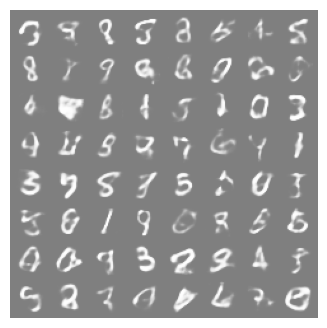

In [ ]:
model.eval()
x_recon = model.sample(64, device)
imshow(torchvision.utils.make_grid(x_recon.view(64, 1, 28, 28).data.cpu()))